In [ ]:
# !pip install -U tensorflow-addons

In [2]:
import numpy as np
import math
import os
import io
import re
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
print(tf.__version__)

2.3.1


## Data

In [4]:
batch_size = 3
img_height = 128
img_width = 128
train_dir = './spectrogram/train/'
test_dir = './spectrogram/test/'

In [5]:
# Import data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 243 files belonging to 81 classes.
Found 81 files belonging to 81 classes.
['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80']


In [6]:
# Normalize data
def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

train_ds = train_ds.map(_normalize_img)
test_ds = test_ds.map(_normalize_img)

## Training

In [7]:
# Define the network
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', input_shape=(img_height,img_width,3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])


In [8]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletHardLoss())

In [9]:
# Train the network
history = model.fit(
    train_ds,
    epochs=5)

Epoch 1/5
81/81 [==============================] - 3s 37ms/step - loss: 0.0451
Epoch 2/5
81/81 [==============================] - 2s 31ms/step - loss: 0.0031
Epoch 3/5
81/81 [==============================] - 3s 32ms/step - loss: 0.0149
Epoch 4/5
81/81 [==============================] - 2s 29ms/step - loss: 0.0117
Epoch 5/5
81/81 [==============================] - 2s 30ms/step - loss: 0.0233


In [10]:
# Get the embeddings
train_images = []
train_labels = []
train_embeddings = []

for image, label in train_ds:
    # Get the embeddings and respective labels
    labels = label.numpy().tolist()
    train_labels += labels
    embeddings = model.predict(image).tolist()
    train_embeddings += embeddings
    # Save the train images to use later on
    train_images += image.numpy().tolist()

test_labels = []
test_embeddings = []

for image, label in test_ds:
    # Get the embeddings and respective labels
    labels = label.numpy().tolist()
    test_labels += labels
    embeddings = model.predict(image).tolist()
    test_embeddings += embeddings

## Testing

In [11]:
acc = 0 # Count number of correct predictions
confused_pairs = [] # Save confused pairs for visualization

for i in range(81):
    test_embedding = test_embeddings[i]
    test_label = test_labels[i]
    
    # Compute distances from the test embedding to all training embeddings
    distances = [np.linalg.norm(np.array(test_embedding)-np.array(train_embedding)) for train_embedding in train_embeddings]
    
    # Find the minimum distance and its index
    min_distance, idx = min((val, idx) for (idx, val) in enumerate(distances))
    
    # Get the most similar label with the testing one
    predict_label = train_labels[idx]
    if predict_label==test_label:
        acc += 1
    else:
        confused_pairs.append(('%02d' % test_label, '%02d' % predict_label, idx))

    
    # Get the true distances from the test embedding to its training embeddings
    true_distances = sorted([distances[j] for j, label in enumerate(train_labels) if label == test_label])
    print(predict_label==test_label)
    print('test_label', test_label, 'predict_label', predict_label)
    print('min_distance', min_distance)
    print('true_distances', true_distances)
    print()
    
print('Accuracy:', acc/81*100)

False
test_label 29 predict_label 39
min_distance 0.5607863090701561
true_distances [0.7060766141252206, 0.8000089607638231, 0.9402216166442023]

True
test_label 23 predict_label 23
min_distance 0.3110719498838292
true_distances [0.3110719498838292, 0.8942366376010018, 1.2994579833483573]

True
test_label 65 predict_label 65
min_distance 0.39110213830371954
true_distances [0.39110213830371954, 0.615291449782144, 0.970242270240414]

True
test_label 78 predict_label 78
min_distance 0.30688420634495406
true_distances [0.30688420634495406, 0.3073215942024105, 0.675192720158737]

True
test_label 59 predict_label 59
min_distance 0.6118154544689011
true_distances [0.6118154544689011, 0.7233194520550579, 1.1095226163842133]

True
test_label 62 predict_label 62
min_distance 0.44062692776585366
true_distances [0.44062692776585366, 0.5967612140482883, 0.6224226546376886]

True
test_label 63 predict_label 63
min_distance 0.20986301659914644
true_distances [0.20986301659914644, 0.3914876919431038, 

<ipython-input-12-b3d602ad1618>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,100))


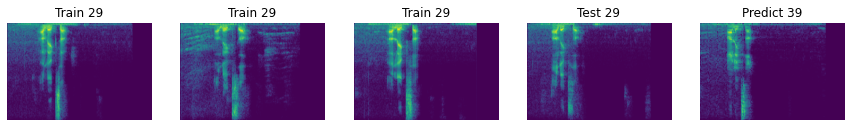

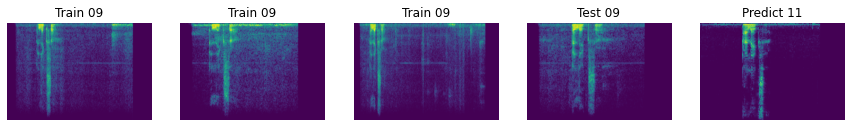

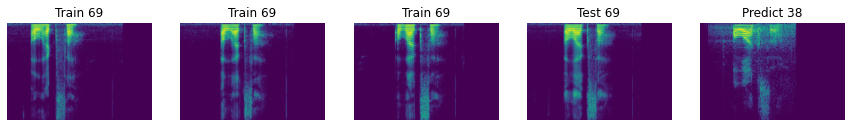

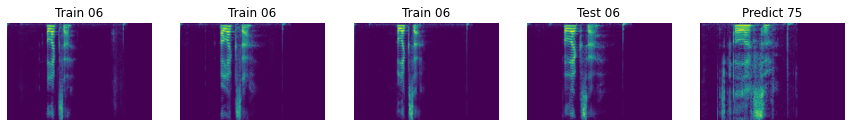

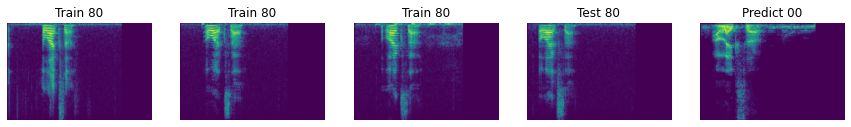

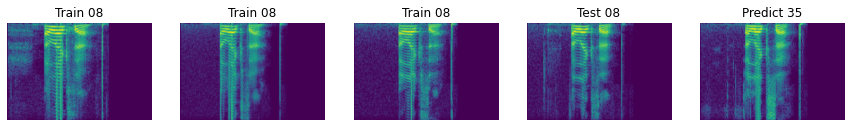

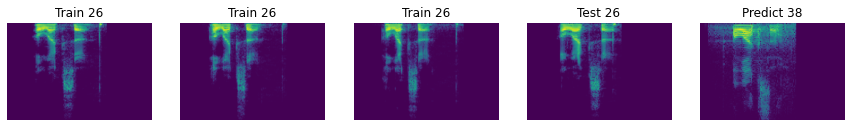

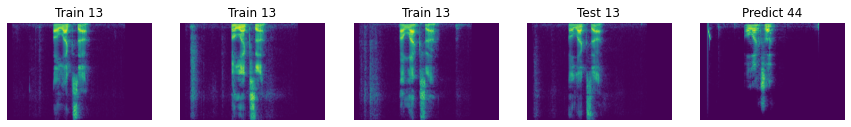

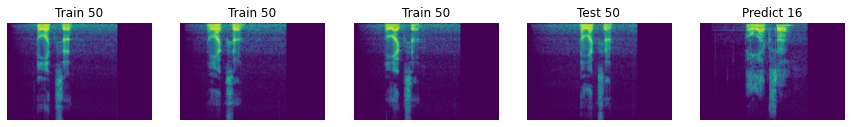

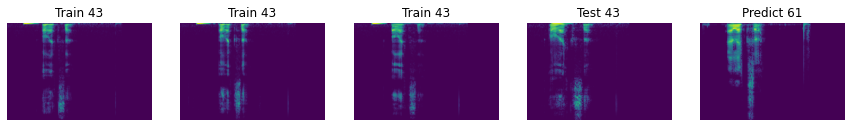

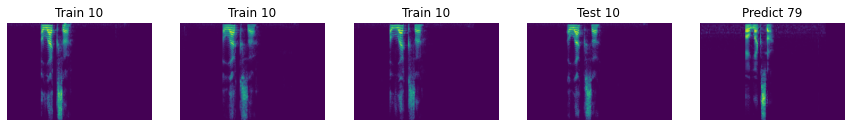

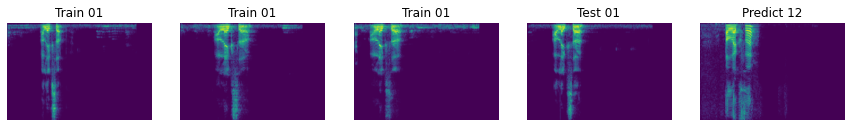

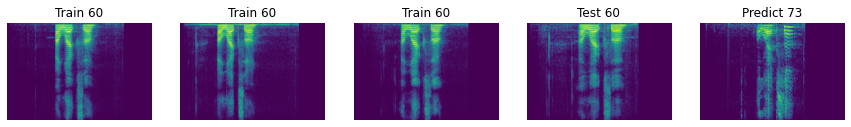

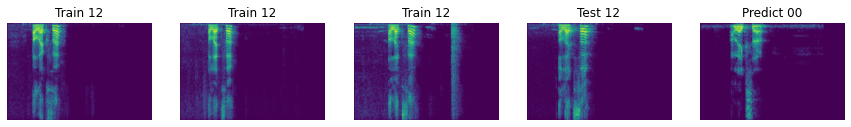

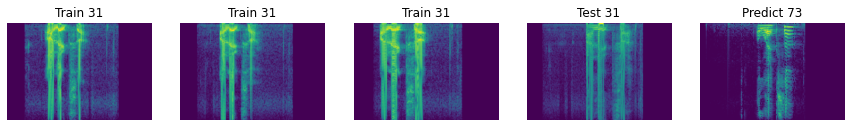

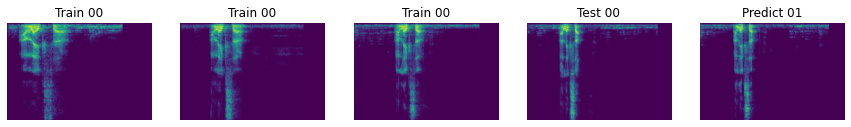

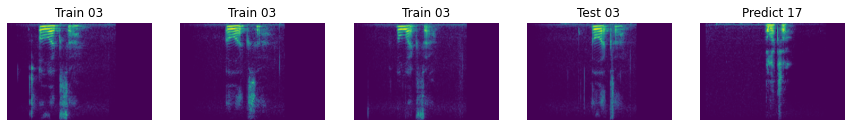

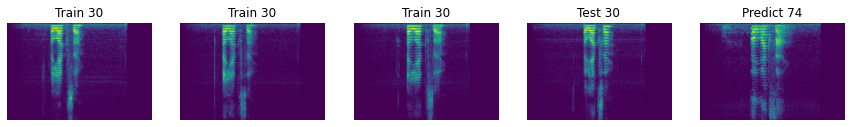

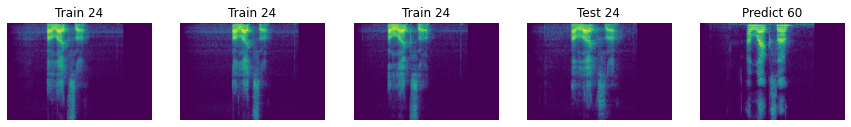

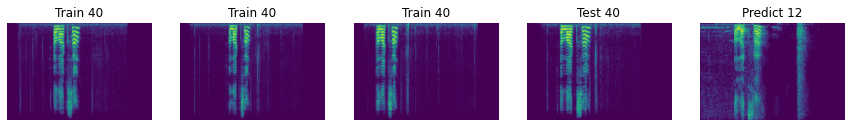

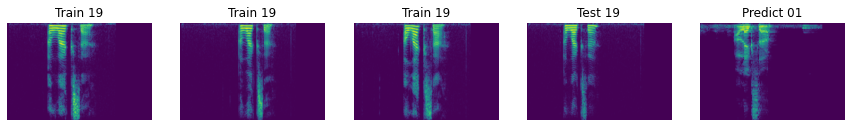

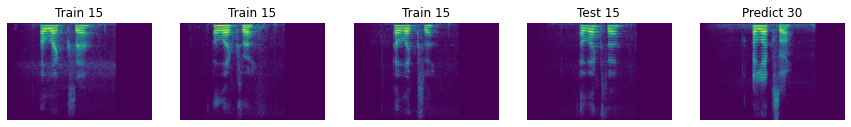

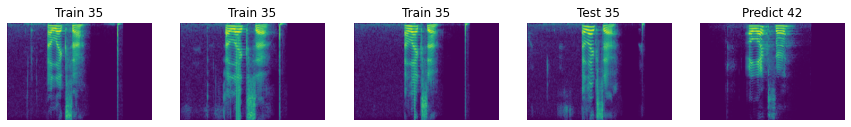

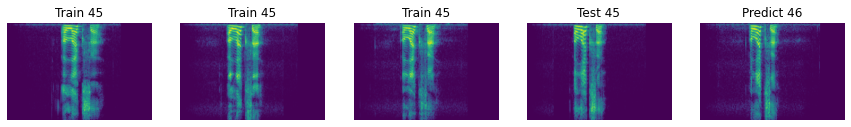

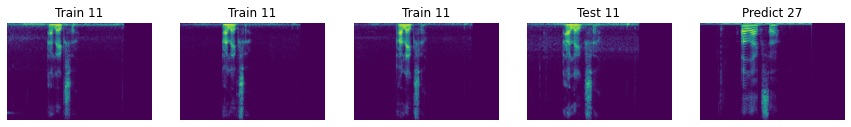

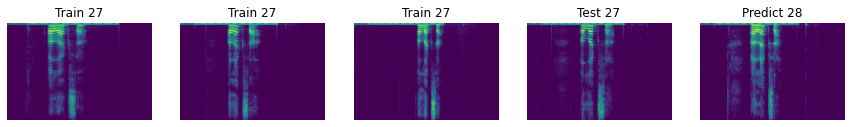

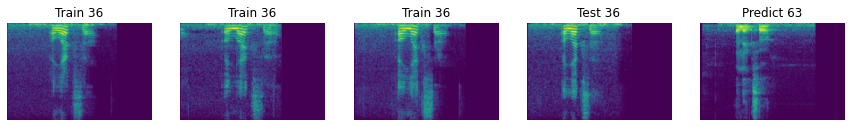

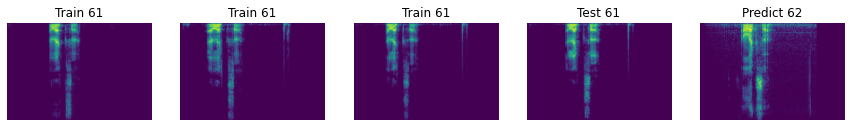

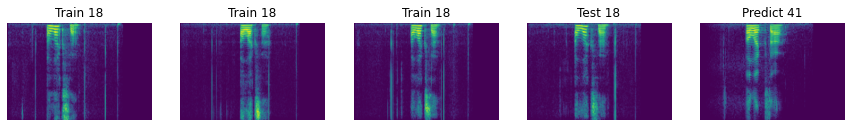

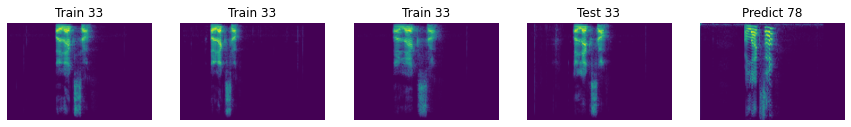

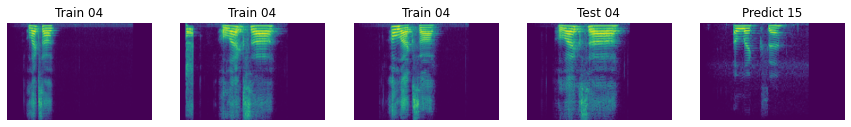

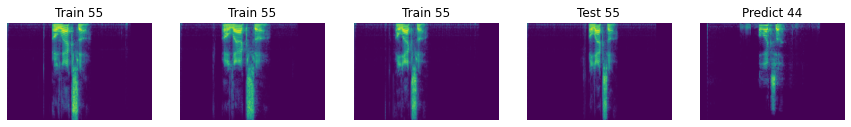

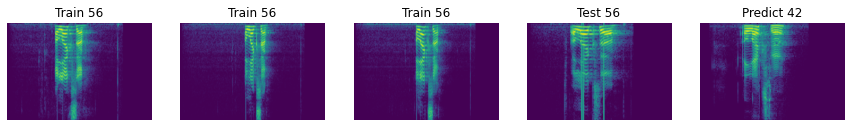

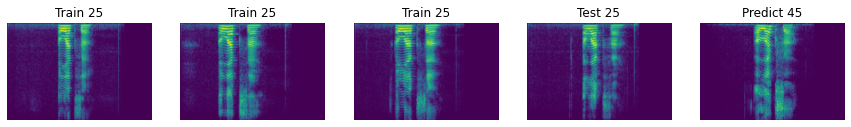

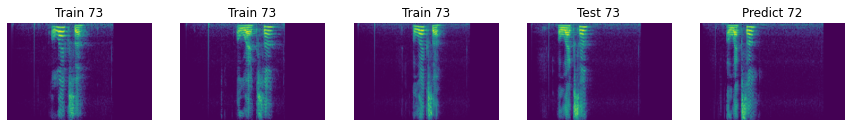

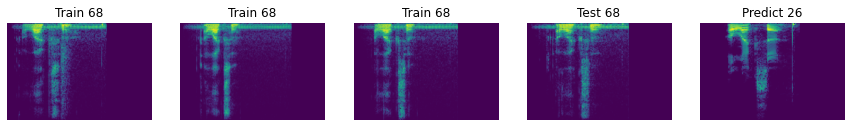

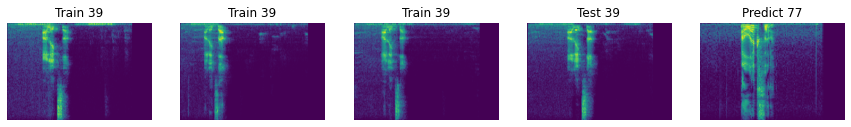

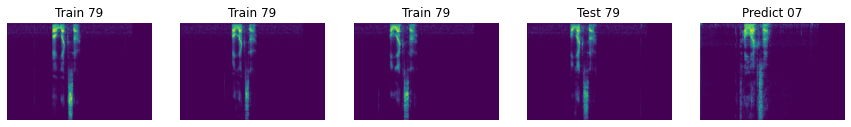

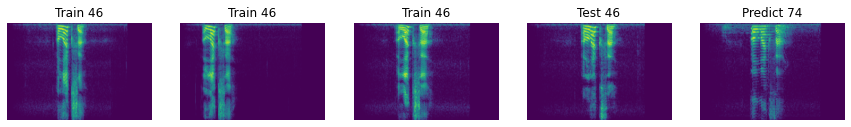

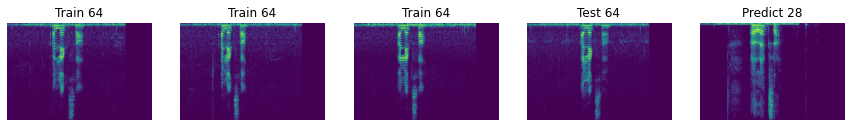

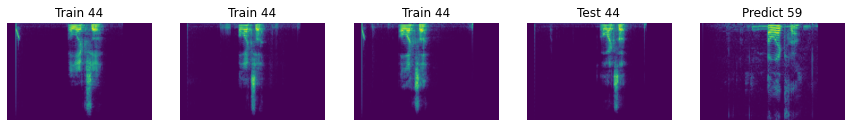

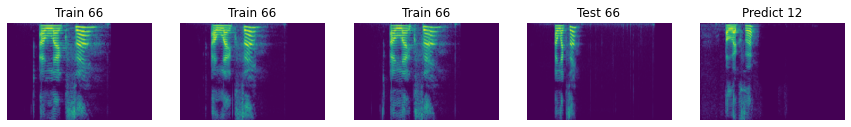

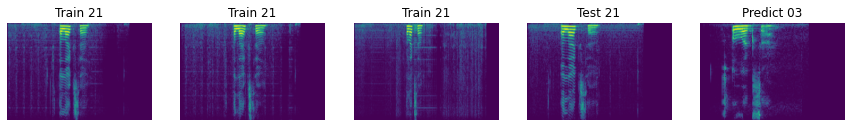

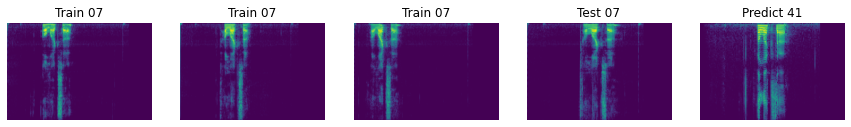

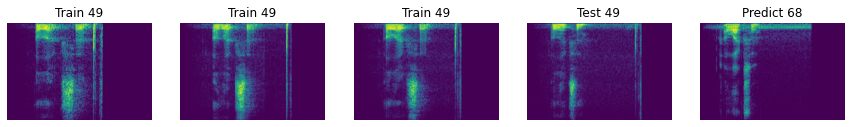

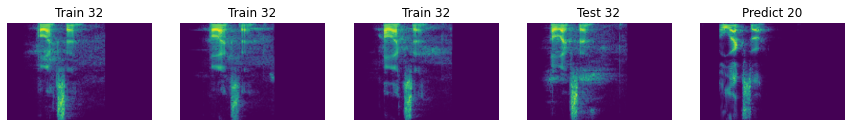

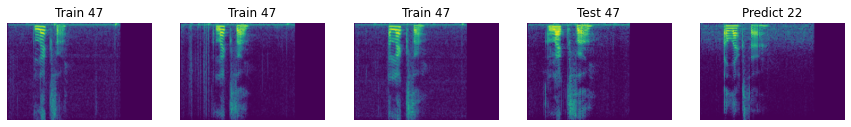

In [12]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = mpimg.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

for i, confused_pair in enumerate(confused_pairs):
    test_label, predict_label, idx = confused_pair    
    train_spectrograms = load_images(f'./spectrogram/train/{test_label}')
    test_spectrogram = load_images(f'./spectrogram/test/{test_label}')
    
    # Visualize spectrograms
    fig = plt.figure(figsize=(15,100))
    for j in range(3):
        # Make subplots
        plt.subplot(len(confused_pairs),5,i*5+j+1)
        plt.title(f'Train {test_label}')
        plt.imshow(train_spectrograms[j], aspect='auto', origin='lower')
        plt.axis('off')
    plt.subplot(len(confused_pairs),5,i*5+4)
    plt.imshow(test_spectrogram[0], aspect='auto', origin='lower')
    plt.title(f'Test {test_label}')
    plt.axis('off')
    plt.subplot(len(confused_pairs),5,i*5+5)
    plt.imshow(train_images[idx], aspect='auto', origin='lower')
    plt.title(f'Predict {predict_label}')
    plt.axis('off')

In [13]:
# # Get the meaning embedding for each class
# mean_embeddings = [0]*81
# for i in range(81):
#     mean_embedding = np.mean(np.array([train_embeddings[k] for k, x in enumerate(train_labels) if x == i]), axis=0)
#     mean_embeddings[i] = mean_embedding

# # Test on mean embeddings
# acc = 0
# for i in range(81):
#     test_embedding = test_embeddings[i]
#     test_label = test_labels[i]
#     dist = [np.linalg.norm(np.array(test_embedding)-np.array(mean_embedding)) for mean_embedding in mean_embeddings]
#     min_dist, idx = min((val, idx) for (idx, val) in enumerate(dist))
#     true_dist = dist[test_label]
#     if idx==test_label:
#         acc += 1
#     print('test_label', test_label, 'idx', idx, idx==test_label)
#     print('min_dist', min_dist, 'true_dist', true_dist)
#     print()
# print(acc/81*100)